# Gaussian process from scratch

see: https://qiita.com/phyblas/items/d756803ec932ab621c56

## Posterior distribution

- $ \mathbf{K} =
    \begin{bmatrix}
        \mathbf{K}_{00} & \mathbf{K}_{01} \\
        \mathbf{K}_{10} & \mathbf{K}_{11}
    \end{bmatrix}
  $

- $ p(\mathbf{y}_1 | \mathbf{x}_1, \mathbf{y}_0, \mathbf{x}_0) = N(\mathbf{y}_1 | \mathbf{\mu}, \mathbf{\Sigma}) $
- $\mathbf{\mu} = \mathbf{K}_{10} \mathbf{K}_{00}^{-1} \mathbf{y}_0 $
- $ \mathbf{\Sigma} = \mathbf{K}_{11} - \mathbf{K}_{10} \mathbf{K}_{00}^{-1} \mathbf{K}_{01} $

## Likelihood

- $ lnf(θ) = −( ln |K_{00}(θ)| + y^T_0 K_{00} (θ) y_0 ) $

In [4]:
# Load modules

import numpy as np
import matplotlib.pyplot as plt

#plt.style.use('seaborn-colorblind')
plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [5]:
# Kernel definition

class Kernel:
    def __init__(self, param, param_ranges):
        self.param = np.array(param)
        self.param_ranges = np.array(param_ranges)

    def __call__(self, x1, x2):
        a1, s, a2 = self.param
        return a1 ** 2 * np.exp(-0.5 * ((x1 - x2) / s) ** 2) + a2 ** 2 * (x1==x2)

In [6]:
# Gaussian process model

class GaussianProcess:
    def __init__(self, kernel, x0, y0):
        self.kernel = kernel
        self.x0 = x0
        self.y0 = y0

    # train the model (without hyper parameter optimization)
    def train(self):
        self.k00 = self.kernel(*np.meshgrid(x0, x0))
        self.k00_1 = np.linalg.inv(self.k00)

    # predict y (=mu, std) from x
    def predict(self, x):
        k00_1 = self.k00_1
        k01 = self.kernel(*np.meshgrid(self.x0, x, indexing='ij'))
        k10 = k01.T
        k11 = self.kernel(*np.meshgrid(x, x))

        mu = k10.dot(k00_1.dot(self.y0))
        sigma = k11 - k10.dot(k00_1.dot(k01))
        std = np.sqrt(sigma.diagonal())
        return mu, std

    # optimize hyper parameters of the kernel
    def optimize(self, n_iter=1000):
        # Variables for sampling a delta
        n_param = len(self.kernel.param)
        theta_range = np.log(self.kernel.param_ranges)
        s = (theta_range[:,1] - theta_range[:,0]) / 10.

        # Start points of theta and ll(=log likelihood)
        theta0 = np.log(self.kernel.param)
        ll0 = self.log_likelihood(self.kernel.param)
        
        # To save samples of theta (= log(self.param)).
        theta_list = []
        
        # To save samples of log likelihoods
        ll_list = []
        
        # MCMC sampling for the number of n_iter iterations
        for i in range(n_iter):
            delta = np.random.normal(0, s, n_param)
            
            # oor(Out Of Range) : ex) [False, False, True]
            oor = self.out_of_range(theta0 + delta, theta_range)
            while(np.any(oor)):
                delta[oor] = np.random.normal(0, s, n_param)[oor]
                oor = self.out_of_range(theta0 + delta, theta_range)
                
            theta1 = theta0 + delta
            ll1 = self.log_likelihood(np.exp(theta1))
            
            # r = exp(log(l1)) / exp(log(l0)) = exp { log(l1) / log(l0) } = exp(log(l1))
            r = np.exp(ll1 - ll0)
            if(r >= 1 or r > np.random.random()):
                theta_list.append(theta1)
                ll_list.append(ll1)
                theta0 = theta1
                ll0 = ll1
                
        # Update kernal parameters
        self.kernel.param = np.exp(theta_list[np.argmax(ll_list)])
        
        # and retrain the model.
        self.k00 = self.kernel(*np.meshgrid(self.x0, self.x0))
        self.k00_1 = np.linalg.inv(self.k00)

    def log_likelihood(self, param):
        tmp_param = self.kernel.param
        self.kernel.param = param
        
        k00 = self.kernel(*np.meshgrid(self.x0, self.x0))
        k00_1 = np.linalg.inv(k00)
        
        self.kernel.param = tmp_param
        # see about np.linalg.slogdet
        # https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.slogdet.html
        return -(np.linalg.slogdet(k00)[1] + self.y0.dot(k00_1.dot(self.y0)))

    def out_of_range(self, theta, theta_range):
        return (theta < theta_range[:,0]) | (theta > theta_range[:,1])

In [7]:
# Fitting target function

def y(x):
    return 5 * np.sin(np.pi / 15 * x) * np.exp(-x / 50)

In [41]:
# plot function

def plot(x0, y0, x1=None, mu=None, std=None, gp=None):
    # Plot original points
    plt.figure(figsize=(10, 5))
    plt.plot(x0, y0, '.')

    # Plot predicted points
    if all([e is not None for e in (x1, mu, std, gp)]):
        plt.plot(x1, mu, alpha=0.5)
        plt.fill_between(x1, mu-std, mu+std, alpha=0.2)    
        plt.title('a=%.3f, s=%.3f, w=%.3f' % tuple(gp.kernel.param))

In [42]:
# Simulation settings

# Sample size
n = 50

# Given points (= x, y)
x0 = np.random.uniform(0, 100, n)
y0 = y(x0) + np.random.normal(0, 1, n)

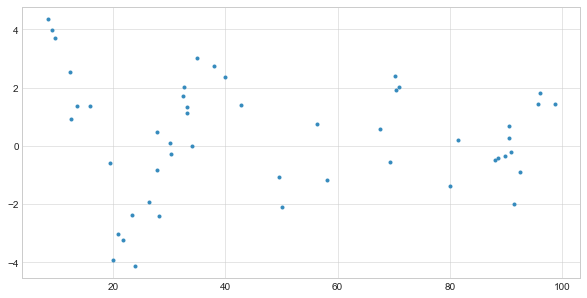

In [43]:
# Plot target function + noize

plot(x0, y0)

In [ ]:
# Definition of a kernel function and a GP

# Initial parameters and its ranges
param0 = [3, 0.6, 0.5]
param_ranges = [[1e-2, 1e2], [1e-2, 1e2], [1e-2, 1e2]]

# Define a kernel
kernel = Kernel(param0, param_ranges)

# Train by gaussian process
gp = GaussianProcess(kernel, x0, y0)

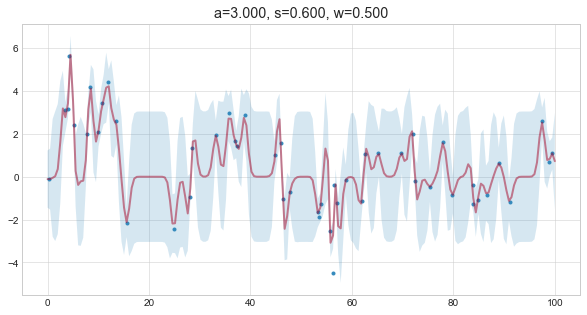

In [33]:
# Prediction without optimization)


gp.train()

# Predict points
x1 = np.linspace(0, 100, 200)
mu, std = gp.predict(x1)

plot(x0, y0, x1, mu, std, gp)

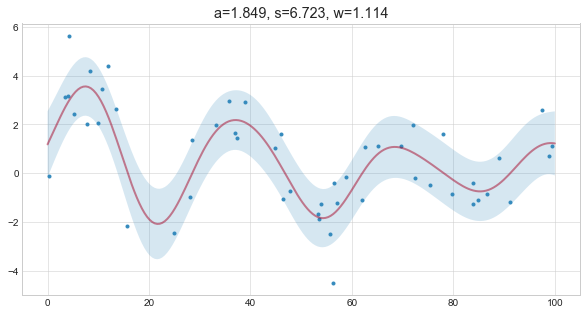

In [34]:
gp.optimize(1000)

mu, std = gp.predict(x1)
plot(x0, y0, x1, mu, std, gp)